In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import community

In [32]:
# load data
city_name = 'Jennings'
nodes_edges_name = 'users&bgt'

nodes = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_edges.csv')

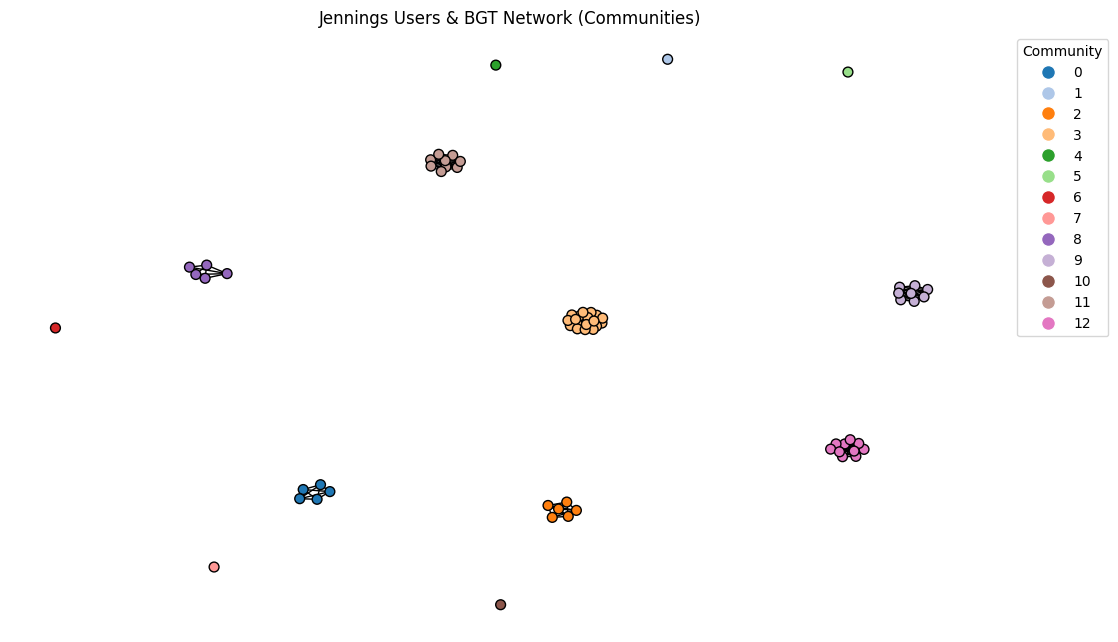

In [51]:
G = nx.Graph()

for _, row in nodes.iterrows():
    G.add_node(row['id'], name=row['people_name'])

for _, row in edges.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])

partition = community.best_partition(G)

palette = plt.get_cmap('tab20')

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos,
        node_color=[palette(partition[node]) for node in G.nodes()],
        node_size=50,
        edge_color='black',
        edgecolors='black',
        width=1,
        with_labels=False)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette(i), markersize=10, label=str(i)) 
                  for i in range(len(set(partition.values())))]
plt.legend(handles=legend_handles, title='Community', bbox_to_anchor=(1, 1), loc='upper left')

plt.title("Jennings Users & BGT Network (Communities)")
plt.show()

In [9]:
# load data
city_name = 'Dublin'
nodes_edges_name = 'categories'

nodes = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_edges.csv')

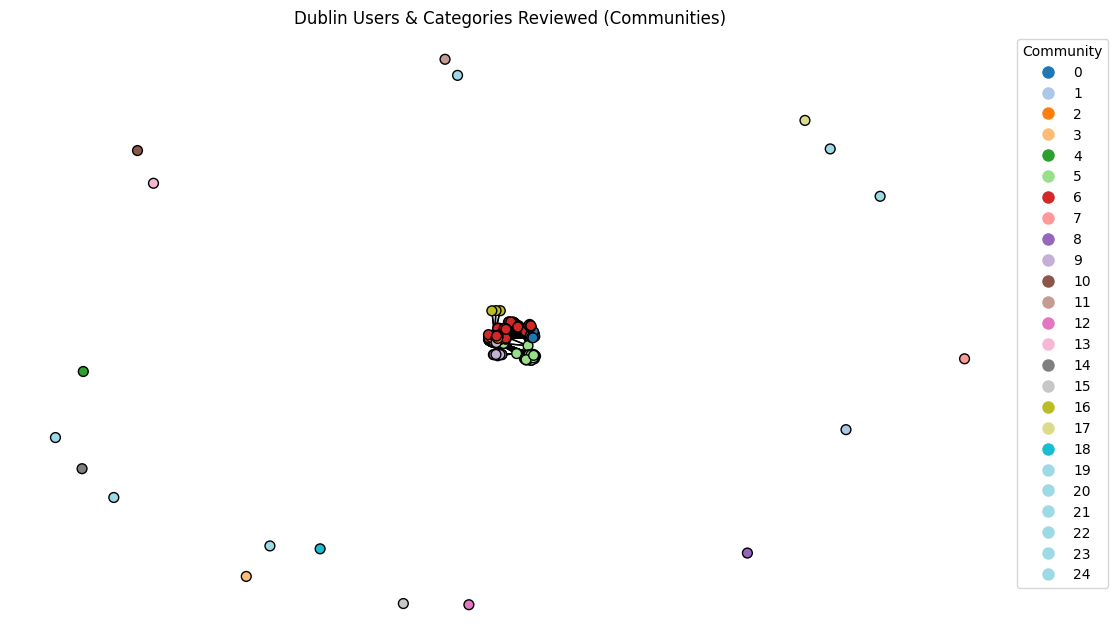

In [10]:
G = nx.Graph()

for _, row in nodes.iterrows():
    G.add_node(row['id'], name=row['people_name'])

for _, row in edges.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])

partition = community.best_partition(G)

palette = plt.get_cmap('tab20')

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos,
        node_color=[palette(partition[node]) for node in G.nodes()],
        node_size=50,
        edge_color='black',
        edgecolors='black',
        width=1,
        with_labels=False)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette(i), markersize=10, label=str(i)) 
                  for i in range(len(set(partition.values())))]
plt.legend(handles=legend_handles, title='Community', bbox_to_anchor=(1, 1), loc='upper left')

plt.title("Dublin Users & Categories Reviewed (Communities)")
plt.show()